In [16]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 텐서플로 ≥2.0 필수
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("감지된 GPU가 없습니다. GPU가 없으면 LSTM과 CNN이 매우 느릴 수 있습니다.")

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)
tf.random.set_seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
plt.style.use('default')

In [17]:
def plot_series(series,
                y=None,
                y_pred=None,
                x_label="$t$",
                y_label="$x(t)$",
                legend=True):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bo", label="Target")
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "rx", markersize=10, label="Prediction")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])
    if legend and (y or y_pred):
        plt.legend(fontsize=14, loc="upper left")

# RNN과 CNN을 사용한 시퀸스 처리
이제는 순환 신경망이다. 그동안은 신호가 한 방향으로 흘렀지만 이제는 뒤쪽으로도 흐른다. <br>
게다가 고정된 길이를 가진 입력뿐만 아니라 임의의 길이를 가지는 시퀸스 데이터를 처리할 수 있다. <br>
예를 들면 문장, 문서, 오디오와 같은 데이터를 입력으로 받을 수 있고 자연어 처리에도 유용하다.
## 순환 뉴런과 순환 층
RNN을 일고 있는 순환 뉴런들은 각 타임 스텝 $t$ 마다 현재 타입 스텝의 입력 $x_{(t)}$ 뿐만 아니라 <br>
이전 타임 스텝의 출력 $y_{(t-1)}$을 입력으로 받는다. 
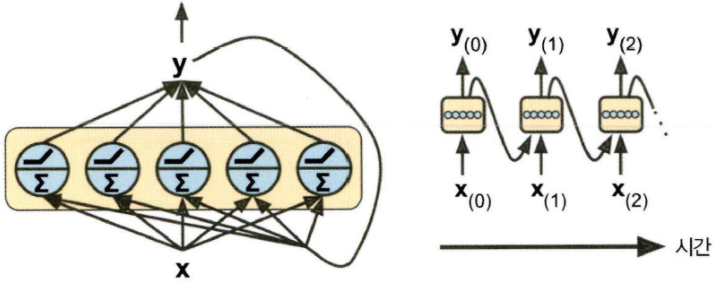 <br>
각 순환 뉴런은 그렇기에 현재 타입 스텝의 입력 $x_{(t)}$ 에 대한 가중치 $W_x$ 와 <br>
이전 타임 스텝의 출력 $y_{(t-1)}$ 에 대한 가중치 $W_y$ 를 가지게 된다. <br>
이를 식을 통해 전체 순환 층의 출력에 대해 표시하면 다음과 같이 나타낼 수 있다. <br><br>
\begin{equation}
    y_{(t)} = \phi\;(\;W_x^T x_{(t)}\;+\;W_y^T y_{(t-1)}+b\;)
\end{equation}<br>
그리고 매 타입스텝 $t$ 에 대한 모든 입력을 행렬 $X_{(t)}$ 로 만들어 미니배치 전체에 대해 나타내면 
<br><br>
\begin{align*}
    Y_{(t)} & = \phi\;(\;X_{(t)}W_x\;+\;Y_{(t-1)}W_y\;+b\;) \\
   & = \phi\;(\;[X_{(t)}\;Y_{(t-1)}]\;W\;+b\;) \quad 
   where\;W = 
   \begin{bmatrix} 
       W_x \\ 
       W_y
   \end{bmatrix}
\end{align*}
<br>
### 메모리 셀
타임 스텝 $t$ 에서 순환 뉴런의 출력은 이전 타임 스텝의 모든 입력에 대한 함수이기도 하다. <br>
따라서 어떤 상태를 보존하는 일종의 **메모리** 형태로 볼 수 있으며 이런 신경망 구성 요쇼를 **메모리 셀** 이라고 부른다. <br>
보통 10스텝 정도로 짧은 패턴을 기억할 수 있는 기본적인 셀이다.<br>
일반적으로 타임 스텝 $t$ 에서 셀의 상태인 $h(t)$ 는 현재 스텝의 입력과 이전 스텝의 상태에 대한 함수이다.<br>
따라서 $h(t)=f(\ h_{(t-1)},\;x_{(t)}\ )$ 로 나타낼 수 있고 왠만하면 출력 값인 $y(t)$ 와 동일하다.
<br>(물론 다음 사진과 같이 복잡한 셀에서는 그러지 않을 수 있다)
<img src ="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRWa2dLAiRCMtt-eEGSUJWS41wvqJEGudSL9A&usqp=CAU" width="600px">
### 입력과 출력 시퀸스
RNN은 입력 시퀸스를 받아서 출력 시퀸스를 만들 수 있다.<br>
예를 들어 최근 N일간의 주식 가격을 입력값으로 받아 각 입력값보다 하루 앞선 가격을 예측하여 출력할 수 있다.<br>
이를 ***시퀸스-투-시퀸스 (Sequence-to-Sequence Network)*** 라고 부른다.<br><br>

아니면 입력값은 시퀸스로 받더라도 출력값은 하나의 벡터값으로 출력할 수 있다.<br>
예를 들면 영화 리뷰 문장(시퀸스)을 보고 영화에 대한 호감도를 -1에서 1까지의 점수(벡터값)로 나타낸다.<br>
이를 ***시퀸스-투-벡터 (Sequence-to-Vector Network)*** 라고 부른다.<br><br>

반대로 첫 타임 스텝에 하나의 벡터를 입력값으로 넘겨주고 출력값으로 하나의 시퀸스를 얻을 수 있다. <br>
예를 들면 이미지를 입력하여 이미지에 대한 캡션을 출력할 수 있다.<br>
이를 ***벡터-투-시퀸스(Vector-to-Sequence Network)*** 라고 부른다<br><br>

그리고 ***인코더*** 라고 부르는 Sequence-to-Vector 네트워크가 특정 문장을 하나의 벡터로 인코딩하고<br>
***디코더*** 라고 부르는 Vector-to-Sequence 네트워크를 통해 해당 벡터를 다른 언어로 번역하는데 이용할 수 있다.<br>
이처럼 ***인코더-디코더*** 라고 불리는 ***이중 단계 모델*** 은 하나의 시퀸스-시퀸스 RNN 모델보다 잘 작동된다.<br>

<img src="https://www.oreilly.com/library/view/neural-networks-and/9781492037354/assets/mlst_1404.png" width="600px">

## RNN 훈련하기
RNN 또한 역전파를 이용하여 훈련된다. RNN을 타임 스텝으로 펼치고 출력값을 기준으로 역전파를 전달한다.  
이를 ***BPTT (BackPropagation Through Time)*** 라고 한다.  
<img src="https://www.oreilly.com/library/view/neural-networks-and/9781492037354/assets/mlst_1405.png" width="500px"><br>
우선 해당 사진처럼 출력 값들(비용 함수는 일부 출력을 무시해도 된다)을 기준으로 비용 함수를 계산한다.<br>
그레디언트 자체는 일부 출력을 기준으로 흐르지만 네트워크를 따라 역방향으로 전파되며 파라미터를 업데이트 시킨다.

## 시계열 예측
시간당, 날짜별 데이터와 같이 타임 스텝마다 하나 이상의 값을 가진 시퀸스 데이터들을 시계열(time series) 데이터라고 부른다.<br>
타임 스텝마다 하나의 값을 가지면 단변량 시계열(univariate time series)이고,<br>
하나 이상의 값을 가지게 되면 다변량 시계열 (multivariate time series)라고 부른다.<br>
RNN을 통하여서 우리는 미래의 값을 예측하거나 누락된 값을 채운다. <br>

In [3]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   웨이브 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20))  # + 웨이브 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)  # + 잡음
    return series[..., np.newaxis].astype(np.float32)

보통 시계열 데이터의 형상은 ***(배치 크기, 타임 스텝 수, 차원 수)*** 로 나타낸다.<br>
단변량의 경우 차원 수가 1이 되고 다변량의 경우 1 이상의 수를 가지게 된다.

In [4]:
n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]
X_train.shape

(7000, 50, 1)

### 기준 성능
기준 성능을 미리 준비하여 모델의 성능을 평가할 때 성능이 나쁜지를 판단하자<br>
각 시계열 데이터의 마지막 값을 바로 이전값으로 그대로 예측하는 것을 순진한 예측(naive forecasting)이라고 부른다.<br>

In [5]:
# 마지막 시계열 값을 그대로 결과값으로 이용한다.

y_pred = X_valid[:,-1]
np.mean(keras.losses.mean_squared_error(y_valid,y_pred))

0.020211367

또는 FCN을 사용하여 구현하는 방법도 있다.

In [6]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50,1]),
    keras.layers.Dense(1)
])
model.compile(loss="mse", optimizer="adam",metrics="mse")
history = model.fit(X_train,y_train,validation_data=(X_valid,y_valid),epochs=20)

Epoch 1/20
219/219 [==============================] - 2s 2ms/step - loss: 0.1001 - mse: 0.1001 - val_loss: 0.0545 - val_mse: 0.0545
Epoch 2/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0379 - mse: 0.0379 - val_loss: 0.0266 - val_mse: 0.0266
Epoch 3/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0202 - mse: 0.0202 - val_loss: 0.0157 - val_mse: 0.0157
Epoch 4/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0131 - mse: 0.0131 - val_loss: 0.0116 - val_mse: 0.0116
Epoch 5/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0103 - mse: 0.0103 - val_loss: 0.0098 - val_mse: 0.0098
Epoch 6/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0089 - mse: 0.0089 - val_loss: 0.0087 - val_mse: 0.0087
Epoch 7/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0080 - mse: 0.0080 - val_loss: 0.0079 - val_mse: 0.0079
Epoch 8/20
219/219 [==============================] - 0s 2ms/step - loss: 0.

In [7]:
model.evaluate(X_test,y_test)

32/32 [==============================] - 0s 1ms/step - loss: 0.0042 - mse: 0.0042


[0.004241826478391886, 0.004241826478391886]

### 심층 RNN
RNN 을 이용하는 경우에서는 셀을 여러 층으로 쌓는 거의 일반적이다. 이를 **심층 RNN** 이라고 부른다. <br>
return_sequences=False 를 사용하면 모든 타임스텝에서 나온 세퀸스가 아닌 마지막 출력만 이용한다. <br>
중간에는 True로 두어서 다음 RNN이 세퀸스 데이터를 받을 수 있도록 하자. <br>

In [10]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

model.compile(loss="mse",optimizer="nadam")
history = model.fit(X_train,y_train, epochs=10, validation_data = (X_valid,y_valid))

Epoch 1/10
219/219 [==============================] - 18s 77ms/step - loss: 0.0489 - val_loss: 0.0123
Epoch 2/10
219/219 [==============================] - 16s 74ms/step - loss: 0.0079 - val_loss: 0.0058
Epoch 3/10
219/219 [==============================] - 16s 73ms/step - loss: 0.0058 - val_loss: 0.0046
Epoch 4/10
219/219 [==============================] - 16s 72ms/step - loss: 0.0049 - val_loss: 0.0050
Epoch 5/10
219/219 [==============================] - 16s 72ms/step - loss: 0.0045 - val_loss: 0.0041
Epoch 6/10
219/219 [==============================] - 16s 74ms/step - loss: 0.0040 - val_loss: 0.0036
Epoch 7/10
219/219 [==============================] - 16s 72ms/step - loss: 0.0038 - val_loss: 0.0038
Epoch 8/10
219/219 [==============================] - 16s 71ms/step - loss: 0.0037 - val_loss: 0.0034
Epoch 9/10
219/219 [==============================] - 16s 72ms/step - loss: 0.0036 - val_loss: 0.0033
Epoch 10/10
219/219 [==============================] - 17s 77ms/step - loss: 0.003

단변량 시계열을 예측하기에 마지막에 하나의 출력값이 필요하다.<br>
굳이 이 과정에서 SimpleRNN을 사용해줄 필요는 없고 tanh 함수 때문에 값이 -1과 1사이에 바운딩 된다.<br>
따라서 다른 활성화 함수를 사용하기 위해 Dense layer로 변경하는 경우가 많다. <br>
이를 위해 2번째 layer의 return_sequences를 지워주자.

In [11]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

model.compile(loss="mse",optimizer="adam")
history = model.fit(X_train,y_train, epochs=20, validation_data = (X_valid,y_valid))

Epoch 1/20
219/219 [==============================] - 12s 51ms/step - loss: 0.0232 - val_loss: 0.0052
Epoch 2/20
219/219 [==============================] - 10s 46ms/step - loss: 0.0043 - val_loss: 0.0036
Epoch 3/20
219/219 [==============================] - 10s 46ms/step - loss: 0.0035 - val_loss: 0.0031
Epoch 4/20
219/219 [==============================] - 10s 47ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 5/20
219/219 [==============================] - 10s 46ms/step - loss: 0.0033 - val_loss: 0.0034
Epoch 6/20
219/219 [==============================] - 10s 45ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 7/20
219/219 [==============================] - 10s 45ms/step - loss: 0.0031 - val_loss: 0.0034
Epoch 8/20
219/219 [==============================] - 10s 46ms/step - loss: 0.0032 - val_loss: 0.0028
Epoch 9/20
219/219 [==============================] - 10s 47ms/step - loss: 0.0031 - val_loss: 0.0028
Epoch 10/20
219/219 [==============================] - 10s 47ms/step - loss: 0.003

### 여러 타임 스탭 예측하기
#### 하나씩 예측하고 값을 추가해주기
이미 훈련된 모델을 사용하여 다음 값을 예측하고 그 다음 이 값을 추가값으로 재활용하는 방식이 있다.<br>
바로 다음 스텝에 대한 예측이 더 미래에 대한 예측보다 정확해서 다른 단순한 예측방식보다 효과적이다.

In [12]:
np.random.seed(43) # 42는 훈련 세트에 있는 첫 번째 시리즈를 반환하기 때문에 다른 값으로 지정합니다

series = generate_time_series(1, n_steps + 10)
X_new, y_new = series[:,:n_steps], series[:,n_steps:]
X=X_new
for step_ahead in range(10):
    y_pred = model.predict(X[:,step_ahead:])[:, np.newaxis,:]
    X = np.concatenate([X,y_pred],axis=1)
Y_pred = X[:, n_steps:]

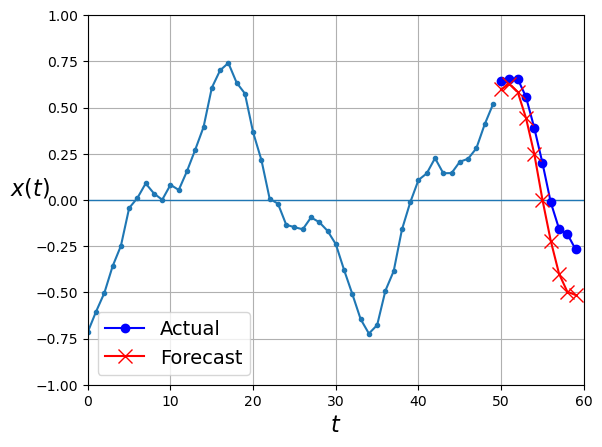

In [13]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "bo-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "rx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

plot_multiple_forecasts(X_new, y_new, Y_pred)
plt.show()

In [ ]:
np.mean(keras.losses.mean_squared_error(Y_pred,y_new))

#### 한번에 여러개 예측 (벡터)
물론 하나씩 추가하면서 하는 것보다 다음 값 10개를 한번에 예측하는 방식도 있다.<br>
Sequence to vector 모델이지만 값 10개를 출력해준다. (타깃이 10개의 값이 담긴 벡터)<br>

In [ ]:
series = generate_time_series(10000, n_steps + 10)
X_train, y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

In [ ]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

In [ ]:
y_pred = model.predict(X_test)
np.mean(keras.losses.mean_squared_error(y_test, y_pred))

#### 모든 타임스텝에서 seq 예측
마지막 타임 스텝에서 다음 값 10개를 예측하도록 훈련시키는 것 보다  
모든 타임 스텝에서 다음 값 10개를 예측하도록 훈련시키면 훈련이 안정적이고 속도가 증가한다.  
따라서 seq to seq RNN으로 변경하여 모든 타임 스텝의 출력에 대한 손실이 포함된다.  
따라서 타깃 값이 입력에 포함된 값을 가질 수 있지만 타임 스텝마다 모델은 이전 타임 스텝만 볼 수 있다.  
이를 ***인과 모델 (causal model)*** 이라고 부른다.

In [19]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, 10))

# 모든 현재 타임 스텝에서 n_steps 만큼 떨어진 값을 예측한다.
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]

Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]
X_train.shape, Y_train.shape

((7000, 50, 1), (7000, 50, 10))

In [20]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
    # TimeDistributed가 각 타임 스텝을 하나의 샘플로 처리하고 Dense층의 입력으로 넣어준다.
    # 이후 다시 seq로 묶어서 사용할 수 있도록 출력해준다.
])


def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])


model.compile(loss="mse",
              optimizer=keras.optimizers.Adam(learning_rate=0.01),
              metrics=[last_time_step_mse])
history = model.fit(X_train,
                    Y_train,
                    epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 13s 51ms/step - loss: 0.0508 - last_time_step_mse: 0.0400 - val_loss: 0.0429 - val_last_time_step_mse: 0.0324
Epoch 2/20
219/219 [==============================] - 11s 48ms/step - loss: 0.0395 - last_time_step_mse: 0.0283 - val_loss: 0.0352 - val_last_time_step_mse: 0.0245
Epoch 3/20
219/219 [==============================] - 10s 47ms/step - loss: 0.0321 - last_time_step_mse: 0.0208 - val_loss: 0.0292 - val_last_time_step_mse: 0.0171
Epoch 4/20
219/219 [==============================] - 11s 51ms/step - loss: 0.0296 - last_time_step_mse: 0.0184 - val_loss: 0.0272 - val_last_time_step_mse: 0.0151
Epoch 5/20
219/219 [==============================] - 11s 51ms/step - loss: 0.0271 - last_time_step_mse: 0.0150 - val_loss: 0.0270 - val_last_time_step_mse: 0.0172
Epoch 6/20
219/219 [==============================] - 11s 49ms/step - loss: 0.0250 - last_time_step_mse: 0.0122 - val_loss: 0.0220 - val_last_time_step_mse: 0.0088
Epoch 7/20
219/2

KeyboardInterrupt: 

## 긴 시퀸스 다루기
시퀸스가 길어질수록 많은 타임 스텝에 걸쳐 실행하면서 펼친 RNN이 매우 깊어진다.  
이 때문에 그레디언트 소실, 폭주문제가 발생하고 훈련 시간이 길어지거나 불안정해진다.  
### 불안정한 그레디언트
보통 심층 신경망에서 사용되던 기법들을 RNN에서 사용하면 이 문제에 대해 접근할 수 있다.  
다만,,, 수렴하지 않는 활성화 함수(ReLU)는 오히려 해로워진다. 왜냐면 타임 스텝이 거듭되면서  
동일한 가중치가 이용되고 따라서 출력값이 특정한 방향으로 폭줄할 수 있다.  
(계속해서 증가하는 방향으로 가중치가 갱신되는 경우)  
작은 학습률을 이용하거나 tanh 와 같은 수렴하는 활성화 함수를 사용하는 것이 가장 현실적인 대안이다.  
만약 그래도 불안정하면 텐서보드로 모니터링하고 그레디언트 클리핑을 진행하자
<br><br>
배치 정규화가 DNN에서는 효과적이 었지만 RNN에서는 효율적이지 않다.  
타임 스텝 사이에 사용할 수 없고 순환 층 사이에서만 이용가능하다는 문제가 있다.  
정확히는 메모리 셀에 배치 정규화 층을 추가하여 스텝마다 현재 입력과 이전 은닉 상태 모두 적용할 수 있다만,,,  
두 값의 실제 스케일과 상관없이 동일한 파라미터로 하나의 층이 작동되기에 좋은 결과가 나오지 못한다.  
이때문에 RNN에서는 ***층 정규화(Layer Normalization)*** 이라는 방식을 채택한다.  
배치 정규화와 비슷하지만 이 레이어는 특성 차원에 대하여 정규화가 진행된다.  
따라서 배치를 어떻게 뽑더라도 통계값이 달라지지 않는다.  
층 정규화는 입력과 은닉 상태의 선형 조합 직후에 사용되며 스케일과 이동 파라미터가 하나씩 학습된다.  

In [ ]:
from tensorflow.keras.layers import LayerNormalization


class LNSimpleRNNCell(keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = keras.layers.SimpleRNNCell(units,
                                                          activation=None)
        self.layer_norm = LayerNormalization()
        self.activation = keras.activations.get(activation)

    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        if inputs is not None:
            batch_size = tf.shape(inputs)[0]
            dtype = inputs.dtype
        return [tf.zeros([batch_size, self.state_size], dtype=dtype)]

    def call(self, inputs, states):
        # 출력과 은닉상태는 동일하므로 new_sates를 무시해도 좋다, 
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.RNN(LNSimpleRNNCell(20),
                     return_sequences=True,
                     input_shape=[None, 1]),
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train,
                    Y_train,
                    epochs=20,
                    validation_data=(X_valid, Y_valid))

In [ ]:
model.summary()

케라스에서 제공되는 모든 RNN cell들은 dropout과 recurrent_dropout 파라미터를 지원한다.  
dropout은 입력에 적용되는 드롭아웃 비율이고 recurrent_dropout은 은닉 상태에 대한 드롭아웃 비율이다.

### 단기 기억 문제
RNN을 걸치면서 데이터가 변환되기에 일부 정보들이 매 훈련 스텝 이후 사라진다.  
사실상 시간이 지나면 첫 입력의 흔적을 찾아볼 수가 없다. 이를 위해 LSTM 같은 셀들이 이용된다.

#### LSTM 셀

ref : https://dgkim5360.tistory.com/entry/understanding-long-short-term-memory-lstm-kr  

<img src="https://tekworld.org/wp-content/uploads/2018/12/Screen-Shot-2018-12-29-at-10.09.20-PM-1024x630.png" width="600px">
<br>
요점은 상태를 장기 기억인 $c_{(t)}$ 와 단기 기억인 $h_{(t)}$ 로 나뉜다는 점이다.<br>
우선 LSTM 셀은 1개의 tanh FC layer와 3개의 sigmoid로 구성된 게이트 제어기로 구성된다.<br>

***메인 layer*** 는 $g_{(t)}$ 를 출력하는 층이다. 이 층은 현재 입력인 $x_{(t)}$ 와 이전의 단기 상태를 분석한다.<br>
$f_{(t)}$ 가 제어하는 ***삭제 게이트*** 에서 장기 기억 일부를 잃고 <br>
***입력 게이트*** 를 통해서 선택적으로 $g_{(t)}$의 일부를 장기 상태에 추가시킨다. ($i_{(t)}$가 제어)<br> 
또한 ***출력 게이트*** 를 통해서 현재 스텝에 대한 출력 값과 단기 상태를 제어한다. ($o_{(t)}$가 제어)<br>
식은 다음과 같다
\begin{align*}
    i_{(t)}& =\sigma(W_{xi}^T x_{(t)}+W_{hi}^T h_{(t-1)}+b_i)\\
    f_{(t)}& =\sigma(W_{xf}^T x_{(t)}+W_{hf}^T h_{(t-1)}+b_f)\\
    o_{(t)}& =\sigma(W_{xo}^T x_{(t)}+W_{ho}^T h_{(t-1)}+b_o)\\
    g_{(t)}& =\tanh(W_{xg}^T x_{(t)}+W_{hg}^T h_{(t-1)}+b_g)\\
    c_{(t)}& =f_{(t)}\otimes c_{(t-1)} + i_{(t)}\otimes g_{(t)}\\
    y_{(t)}& =h_{(t)} = o_{(t)} \otimes \tanh(c_{(t)})
\end{align*}<br>
$W_{x?}$는 입력 벡터 $x_{(t)}$ 에 대한 가중치 행렬이고 $W_{h?}$는 입력 벡터 $h_{(t-1)}$ 에 대한 가중치 행렬이다.<br>
$b_?$는 4개 층 각각에 대한 편향이며 텐서플로는 $b_f$ 를 0이 아닌 1로 채워진 벡터로 초기화해준다.

In [14]:
# 가장 일반적인 방식 (GPU에서 실행될 때 최적화된 구현을 사용하므로 일반적으로 이용됨)

model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

# 범용적인 keras.layers.RNN 층에 LSTMCell을 넣어주는 경우

model = keras.models.Sequential([
    keras.layers.RNN(keras.layers.LSTMCell(20),
                     return_sequences=True,
                     input_shape=[None, 1]),
    keras.layers.RNN(keras.layers.LSTMCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

#### GRU 셀
Gated Recurrent Unit (GRU) 셀은 LSTM의 간소화 버전이다.<br>
<img src="https://cdn-images-1.medium.com/freeze/max/1000/1*GSZ0ZQZPvcWmTVatAeOiIw.png?q=20" width="600px">
<br>
리셋 게이트에서 이전 시점의 hidden state의 값을 얼마나 활용할지 ($r_t$)를 정하고  
이 값을 이용하여 업데이트 게이트에서 과거와 현재의 정보를 현재 출력에 얼마나 반영할지를 비율을 정한다.
```python
keras.layers.GRU()     # keras.layers.SimpleRNN, LSTM과 동일
keras.layers.GRUCell() # 범용 keras.layers.RNN layer에 넣을 때 사용
```

####  Conv1D를 사용한 시퀸스 줄이기
Conv1D layer를 사용할 경우, 커널이 슬라이딩하여 1D 특성맵을 출력하여 준다.<br>
스트라이드 1과 "same"을 이용한다면 출력값의 길이와 입력값의 길이가 같겠지만<br>
1보다 큰 스트라이드와 "valid" 패딩을 이용한다면 출력값의 길이가 짧아진다.<br>
이를 사용하여 시퀸스 길이를 줄여주면 RNN의 층들이 더 긴 패턴을 감지하는 데 도움이 된다.

In [21]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding="valid",
                        input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train[:, 3::2], epochs=20,
                    validation_data=(X_valid, Y_valid[:, 3::2]))

Epoch 1/20
219/219 [==============================] - 8s 9ms/step - loss: 0.0681 - last_time_step_mse: 0.0601 - val_loss: 0.0477 - val_last_time_step_mse: 0.0396
Epoch 2/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0414 - last_time_step_mse: 0.0340 - val_loss: 0.0367 - val_last_time_step_mse: 0.0285
Epoch 3/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0338 - last_time_step_mse: 0.0257 - val_loss: 0.0307 - val_last_time_step_mse: 0.0218
Epoch 4/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0282 - last_time_step_mse: 0.0184 - val_loss: 0.0259 - val_last_time_step_mse: 0.0152
Epoch 5/20
219/219 [==============================] - 1s 7ms/step - loss: 0.0249 - last_time_step_mse: 0.0143 - val_loss: 0.0246 - val_last_time_step_mse: 0.0141
Epoch 6/20
219/219 [==============================] - 1s 7ms/step - loss: 0.0234 - last_time_step_mse: 0.0125 - val_loss: 0.0227 - val_last_time_step_mse: 0.0115
Epoch 7/20
219/219 [========

#### WaveNet
2016년에 발표된 WaveNet은 층마다 ***뉴런의 입력이 떨어져 있는 간격인 팽창 비율(dilation rate)*** 을
<br>
2배로 눌리는 1D 합성곱 층을 쌓는다. 그 덕분에 ***하위 층은 단기 패턴*** 을 ***상위층은 장기 패턴*** 을 학습한다.<br>
덕분에 시퀸스가 아무리 길더라도 효율적으로 처리할 수 있으며 뿐만 아니라 1,2,4,8...,512의 팽창 비율을 가지는
<br>
합성곱 층 10개를 하나의 팽창 층(dilated Conv)으로 두고 총 30개를 잔차 블록으로 연결했다.
<img src="https://miro.medium.com/proxy/1*tiZ-jX0ECHwEysGWjzkzDA.png" width="600px">
<br>
<img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FcZjoyG%2FbtqCRytGZrQ%2FyjSh2XFRPkpGB5MH6XJ85K%2Fimg.png" width="600px"><br>
이런 WaveNet 논문은 텍스트 투 스피치 작업을 포함하여 여러 오디오 문제에서 좋은 성능을 달성했다.<br>